# Plot safe prediction horizon

## Imports

In [1]:
import torch
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from time import strftime, localtime

## Set plot options

In [2]:
# plot inline interactive
%matplotlib widget    
# plot external
#%matplotlib qt
# plot inline
#%matplotlib inline    

In [3]:
# set option to show plot of save as pdf or pgf -> set to either 'pdf' or 'pgf' for LaTeX
save_fig = False

In [4]:
# set height and width of figure
figure_width = 6
figure_height = 4

In [5]:
# set deceleration for t_phys
deceleration = 8

In [6]:
# set bin size for vel (in m/s)
bin_size = 0.25

# set weight for smoothing
weight = 4

## helper functions

In [7]:
def exponential_moving_average(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

In [8]:
def moving_average(scalars, weight):  # Weight must be interger value
    return np.convolve(scalars, np.ones((weight,))/weight, mode='same') 

In [9]:
def sort_and_bin(data, precission):
    data = data[data[:,0].argsort()]
    data[:,0] = np.round(data[:,0]/precission)*precission
    return data

In [10]:
def get_data_mean_std(data):

    tensor = torch.tensor(data)
    _, counts = torch.unique_consecutive(tensor[:,0], return_counts=True)   # get split idx after each timestep
    tensor = torch.split(tensor, counts.tolist())                           # split array after each unique time

    mean = np.array([torch.mean(t[:,1]) for t in tensor])
    std = np.array([torch.std(t[:,1]) for t in tensor])

    return mean, std

## Plot functions

In [11]:
def plot_horizon(ax, data, bin_size, **kw):

    data = sort_and_bin(data, bin_size)
    x = np.unique(data[:,0])

    mean, std = get_data_mean_std(data)

    ax.plot(x, mean, '.-', **kw)
    ax.fill_between(x, mean - std, mean + std, alpha=0.2, label=f'$\sigma_{{{list(list(kw.items())[-1])[-1]}}}$')
    ax.margins(x=0)

In [12]:
def plot_t_model(ax, data_list, bin_size, weight, plot_std, **kw):

    # concat data
    data = np.concatenate([data for data in data_list])

    # sort data 
    data_sorted = sort_and_bin(data, bin_size)
    x = np.unique(data_sorted[:,0])

    mean, std = get_data_mean_std(data_sorted)
    if weight != 0: 
        mean_new = moving_average(mean, weight)
        mean = np.concatenate((mean[:2], mean_new[2:]))

    ax.plot(x, mean, '-', **kw)

    if plot_std:
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, label='$\sigma_{model}$')
        ax.margins(x=0)

In [13]:
def plot_t_phys(ax, data, bin_size, deceleration, **kw):

    data = sort_and_bin(data, bin_size)
    x = np.unique(data[:,0])
    t_phy = x/deceleration
    ax.plot(x, t_phy, '-', **kw)

In [14]:
def plot_t_comf(ax, data, weight, plot_std, plot_std_avrg, **kw):

    time = data[:,0]
    mean = data[:,2]
    max_ = data[:,1]
    min_ = data[:,3]

    if plot_std_avrg: 
        max_new = moving_average(max_, weight)
        max_ = np.concatenate((max_[:2], max_new[2:]))
        min_new = moving_average(min_, weight)
        min_ = np.concatenate((min_[:2], min_new[2:]))

    if weight != 0: 
        mean_new = moving_average(mean, weight)
        mean = np.concatenate((mean[:2], mean_new[2:]))
        ax.plot(time, mean, '-', **kw)
    else:    
        ax.plot(time, mean, '.', **kw)

    if plot_std:
        try:    ax.fill_between(time, min_, max_, color=kw['color'], edgecolor=None, alpha=0.2, label=plot_std)
        except: ax.fill_between(time, min_, max_, alpha=0.2, label=plot_std)
        ax.margins(x=0)    

## Plot

### config

In [15]:
if save_fig:    
    mpl.use(save_fig)
    plt.rcParams.update({   "font.family": "serif", # serif/main font for text
                            "text.usetex": True,    # inline math for ticks
                            "pgf.rcfonts": False})  # fonts not from rc parameters

### load data

In [ ]:
directory = '../logs/self_eval_avs_data/'

In [16]:
# K = 1
data_lstm = np.load(directory+'pred_horizon-3s6s-LSTM-MSE-K1-av2-2023-01-18_08-04.npy')
data_vectornet = np.load(directory+'pred_horizon-3s6s-VectorNet-GNLLL-K1-av2-2023-01-17_16-31.npy')
# K = 6
# data_vectornet = np.load(directory+'pred_horizon-3s6s-VectorNet-MSE-K6-av2-2023-01-20_13-48.npy')
# data_lstm = np.load(directory+'pred_horizon-3s6s-LSTM-MSE-K6-av2-2023-01-20_16-36.npy')

# lanchange data
lane_change = np.genfromtxt(directory+'lanechangeDuration.csv', skip_header=1, delimiter=',')
lane_change = lane_change[4:]

# velocitys in av2
vel_train = np.load(directory+'end-velocities-train_av2.npy')
vel_val = np.load(directory+'end-velocities-val_av2.npy')

# get max velocity
max_vel = int(max(np.amax(vel_val), np.max(vel_train)))

### $t_{model}$

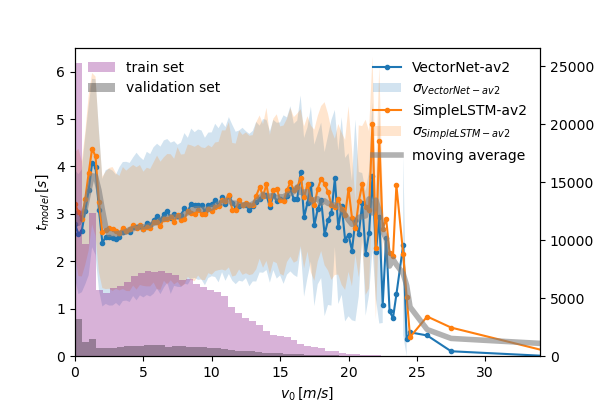

In [17]:
# define figure
fig, ax1 = plt.subplots()
fig.set_size_inches(w=figure_width, h=figure_height)

# plot data
plot_horizon(ax1, data_vectornet, bin_size, label=f'VectorNet-av2')
plot_horizon(ax1, data_lstm, bin_size, label=f'SimpleLSTM-av2')

# plot moving average
plot_t_model(ax1, [data_lstm, data_vectornet], bin_size, weight, plot_std=False, alpha=0.6, color='grey', linewidth=4, label=f'moving average')

# histogram of data counts
ax2 = ax1.twinx()
ax2.hist(vel_train,  bins=int(np.amax(vel_train))*2, alpha = 0.3, color='purple', label=f'train set')
ax2.hist(vel_val,  bins=int(np.amax(vel_val))*2, alpha = 0.3, color='black', label=f'validation set')

# labels
ax1.set_ylabel('$t_{model}\,[s]$')
ax2.set_ylabel('$N$')
ax1.set_xlabel("$v_0\,[m/s]$")
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper left', frameon=False)

# axis
plt.xlim([0, max_vel])
ax1.set_ylim([0, 6.5])

if save_fig:    plt.savefig(directory+f'plots/safe-prediction-horizon-av2-vectornet-lstm-{strftime("%Y-%m-%d", localtime())}.{save_fig}')
else:           plt.show()

### $t_{comfort}$

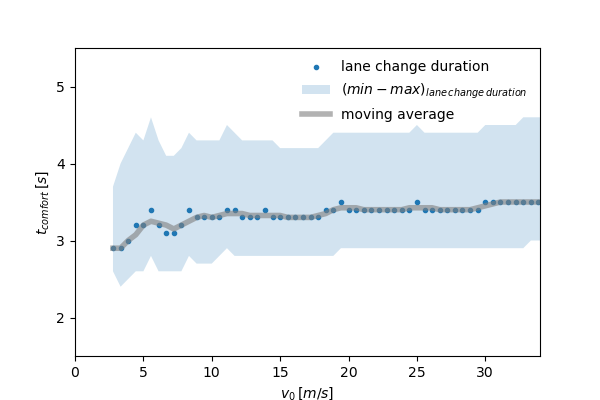

In [18]:
# define figure
fig, ax1 = plt.subplots()
fig.set_size_inches(w=figure_width, h=figure_height)

# plot data
plot_t_comf(ax1, lane_change, weight=0, plot_std='$(min-max)_{lane\,change\,duration}$', plot_std_avrg=False, label='lane change duration')
plot_t_comf(ax1, lane_change, weight=weight, plot_std=False, plot_std_avrg=False,  alpha=0.6, color='grey', linewidth=4, label=f'moving average')

# labels
ax1.set_ylabel('$t_{comfort}\,[s]$')
ax1.set_xlabel("$v_0\,[m/s]$")
ax1.legend(loc='upper right', frameon=False)

# axis
plt.xlim([0, max_vel])
plt.ylim([1.5, 5.5])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))


if save_fig:    plt.savefig(directory+f'plots/t_comfort-{strftime("%Y-%m-%d", localtime())}.{save_fig}')
else:           plt.show()

### $t_{model}$, $t_{phys}$, $t_{comf}$

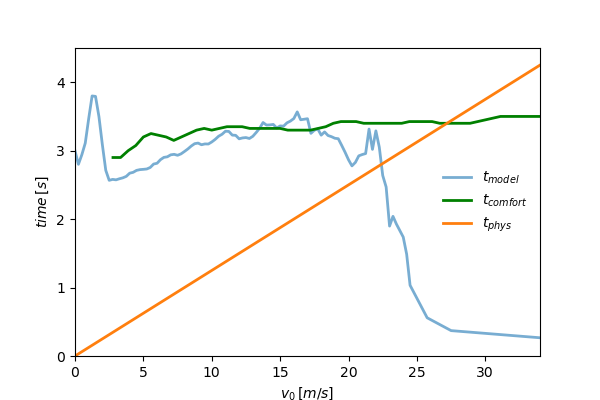

In [19]:
# define figure
fig, ax1 = plt.subplots()
fig.set_size_inches(w=figure_width, h=figure_height)

# plot moving average
plot_t_model(ax1, [data_lstm, data_vectornet], bin_size, weight, plot_std=False, alpha=0.6, linewidth=2, label='$t_{model}$')

# plot t confort
plot_t_comf(ax1, lane_change,  weight=weight, plot_std=False,  plot_std_avrg=True, linewidth=2, label='$t_{comfort}$', color='green')

# plot t phys
plot_t_phys(ax1, data_vectornet, bin_size, deceleration, linewidth=2, label='$t_{phys}$')


# labels
ax1.set_ylabel('$time\,[s]$')
ax1.set_xlabel("$v_0\,[m/s]$")
ax1.legend(loc='center right', frameon=False)

# axis
plt.xlim([0, max_vel])
ax1.set_ylim([0, 4.5])
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))


if save_fig:    plt.savefig(directory+f'plots/t_comfort-t_model-t_phys-{strftime("%Y-%m-%d", localtime())}.{save_fig}')
else:           plt.show()